In [3]:

!pip install pmdarima --no-cache-dir

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 140.1 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

In [5]:
#importamos el dataset directo desde drive
file_id = "1NC3BeDqkamlA5TsN3WzAljQYnRtjjiAN"  # id AGU02_energia.xlsx
url = f"https://drive.google.com/uc?id={file_id}"

# Leer archivo Excel
df = pd.read_excel(url, engine="openpyxl")


# ARIMA

## PRUEBA ADF

In [6]:

df_adf = df.copy()
df_adf.set_index('Fecha', inplace=True)

# 2. Seleccionar la serie de potencia activa generada
serie = df_adf['Potencia_activa_generada [kW]'].dropna()

# 3. Ejecutar prueba Dickey-Fuller aumentada (ADF)
resultado = adfuller(serie)

# 4. Imprimir resultados
print("=== Prueba de Dickey-Fuller Aumentada ===")
print(f"Estadístico ADF: {resultado[0]:.4f}")
print(f"p-valor: {resultado[1]:.10f}")
print(f"Nº de rezagos usados: {resultado[2]}")
print(f"Nº de observaciones: {resultado[3]}")
print("Valores críticos:")
for clave, valor in resultado[4].items():
    print(f"   Nivel {clave}: {valor:.4f}")


=== Prueba de Dickey-Fuller Aumentada ===
Estadístico ADF: -6.8555
p-valor: 0.0000000017
Nº de rezagos usados: 31
Nº de observaciones: 18621
Valores críticos:
   Nivel 1%: -3.4307
   Nivel 5%: -2.8617
   Nivel 10%: -2.5669


## ENTRENAMIENTO Y EVALUACION DEL MODELO

In [7]:
df_ARI = df.copy()
df_ARI.set_index('Fecha', inplace=True)

# 2. Preparar la serie de 15 minutos
serie_15min_ARI = df_ARI['Potencia_activa_generada [kW]'].dropna()

# 3. Separar entrenamiento y prueba
train_size_ARI = int(len(serie_15min_ARI) * 0.8)
train_ARI = serie_15min_ARI[:train_size_ARI]
test_ARI = serie_15min_ARI[train_size_ARI:]


In [8]:
# 4. Ajustar modelo ARIMA automáticamente
modelo_ARI = auto_arima(train_ARI,
                    seasonal=False,
                    stepwise=True,
                    suppress_warnings=True,
                    trace=True)

print("\nResumen del mejor modelo:")
print(modelo_ARI.summary())


Performing stepwise search to minimize aic


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=267703.838, Time=14.39 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=270612.594, Time=0.58 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=268705.726, Time=0.76 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=268091.001, Time=2.28 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[0]             : AIC=270610.618, Time=0.24 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=267766.877, Time=13.40 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=267739.360, Time=4.88 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=267740.867, Time=11.54 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=267665.022, Time=16.51 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=267669.486, Time=10.19 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=267576.094, Time=43.06 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=267581.052, Time=38.45 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=267580.224, Time=52.37 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=267670.544, Time=26.24 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=267587.434, Time=35.33 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=267574.286, Time=54.93 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,4)(0,0,0)[0] intercept   : AIC=267576.134, Time=60.44 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,5)(0,0,0)[0] intercept   : AIC=267581.890, Time=45.14 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,5)(0,0,0)[0] intercept   : AIC=267575.294, Time=66.86 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=267578.606, Time=50.91 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,5)(0,0,0)[0] intercept   : AIC=267578.085, Time=70.96 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,4)(0,0,0)[0]             : AIC=267572.601, Time=13.67 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,4)(0,0,0)[0]             : AIC=267574.732, Time=16.09 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,3)(0,0,0)[0]             : AIC=267579.618, Time=15.33 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,4)(0,0,0)[0]             : AIC=267573.838, Time=10.92 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,5)(0,0,0)[0]             : AIC=267572.719, Time=26.19 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[0]             : AIC=267574.242, Time=11.51 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,5)(0,0,0)[0]             : AIC=267568.883, Time=18.94 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,5)(0,0,0)[0]             : AIC=267567.513, Time=14.61 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,5)(0,0,0)[0]             : AIC=267565.806, Time=7.97 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,5)(0,0,0)[0]             : AIC=267693.687, Time=3.72 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,4)(0,0,0)[0]             : AIC=267633.519, Time=7.65 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,4)(0,0,0)[0]             : AIC=267697.364, Time=1.76 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,4)(0,0,0)[0]             : AIC=267668.565, Time=11.23 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=267567.607, Time=40.87 sec

Best model:  ARIMA(1,1,5)(0,0,0)[0]          
Total fit time: 819.943 seconds

Resumen del mejor modelo:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                14922
Model:               SARIMAX(1, 1, 5)   Log Likelihood             -133775.903
Date:                Wed, 18 Jun 2025   AIC                         267565.806
Time:                        15:10:15   BIC                         267619.079
Sample:                    05-02-2024   HQIC                        267583.486
                         - 10-04-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9506      0.004   

In [9]:
# 5. Predecir
pred_ARI = modelo_ARI.predict(n_periods=len(test_ARI))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [10]:
# 6. Métricas de evaluación
mae_ARI = mean_absolute_error(test_ARI, pred_ARI)
rmse_ARI = np.sqrt(mean_squared_error(test_ARI, pred_ARI))
r2_ARI = r2_score(test_ARI, pred_ARI)

print(f"\nMAE_ARIMA : {mae_ARI:.2f}")
print(f"RMSE_ARIMA: {rmse_ARI:.2f}")
print(f"R²_ARIMA  : {r2_ARI:.4f}")



MAE_ARIMA : 9028.99
RMSE_ARIMA: 15052.83
R²_ARIMA  : -0.0024


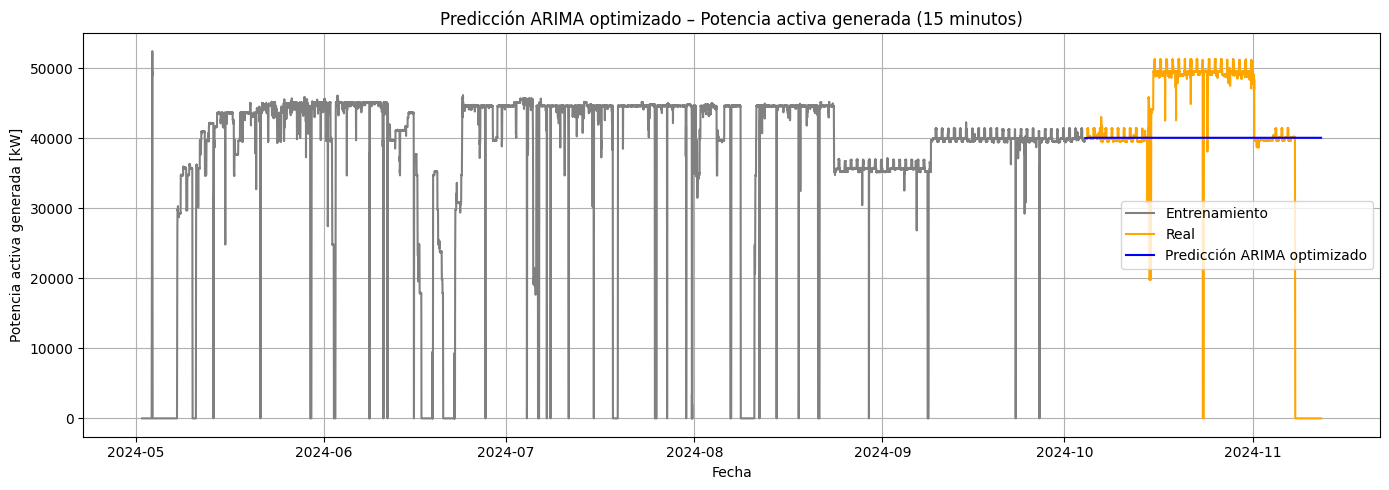

In [11]:
# 7. Gráfico general
plt.figure(figsize=(14, 5))
plt.plot(train_ARI.index, train_ARI, label='Entrenamiento', color='gray')
plt.plot(test_ARI.index, test_ARI, label='Real', color='orange')
plt.plot(test_ARI.index, pred_ARI, label='Predicción ARIMA optimizado', color='blue')
plt.title('Predicción ARIMA optimizado – Potencia activa generada (15 minutos)')
plt.xlabel('Fecha')
plt.ylabel('Potencia activa generada [kW]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# RANDOM FOREST

## ENTRENAMIENTO Y EVALUACION DEL MODELO

In [12]:
# 1. Cargar datos
df_RF = df.copy()

# 2. Crear variables temporales
df_RF['Hora'] = df_RF['Fecha'].dt.hour
df_RF['Minuto'] = df_RF['Fecha'].dt.minute
df_RF['Día'] = df_RF['Fecha'].dt.day
df_RF['Mes'] = df_RF['Fecha'].dt.month
df_RF['Año'] = df_RF['Fecha'].dt.year
df_RF['DíaSemana'] = df_RF['Fecha'].dt.dayofweek

# 3. Definir X e y
X_RF = df_RF[['Hora', 'Minuto', 'Día', 'Mes', 'Año', 'DíaSemana']]
y_RF = df_RF['Potencia_activa_generada [kW]']


In [13]:
# 4. Separar en entrenamiento y prueba
X_train_RF, X_test_RF, y_train_RF, y_test_RF = train_test_split(X_RF, y_RF, shuffle=False, test_size=0.2)

In [14]:
# 5. Ajustar Random Forest
modelo_RF = RandomForestRegressor(n_estimators=3000, max_depth=12, min_samples_split=100,
                                  random_state=42)
modelo_RF.fit(X_train_RF, y_train_RF)


RandomForestRegressor(max_depth=12, min_samples_split=100, n_estimators=3000,
                      random_state=42)

In [15]:
# 6. Predicción
y_pred_RF = modelo_RF.predict(X_test_RF)

In [16]:
y_pred_RF

array([39923.74943787, 39923.74943787, 39923.9684766 , ...,
       39584.68914389, 39584.68914389, 39790.15951242])

In [17]:
# 7. Evaluar errores
mae_RF = mean_absolute_error(y_test_RF, y_pred_RF)
rmse_RF = np.sqrt(mean_squared_error(y_test_RF, y_pred_RF))
r2_RF = r2_score(y_test_RF, y_pred_RF)
print(f"MAE_RF: {mae_RF:.2f}")
print(f"RMSE_RF: {rmse_RF:.2f}")
print(f"R²_RF (coeficiente de determinación): {r2_RF:.4f}")

MAE_RF: 8035.33
RMSE_RF: 11984.44
R²_RF (coeficiente de determinación): 0.3646


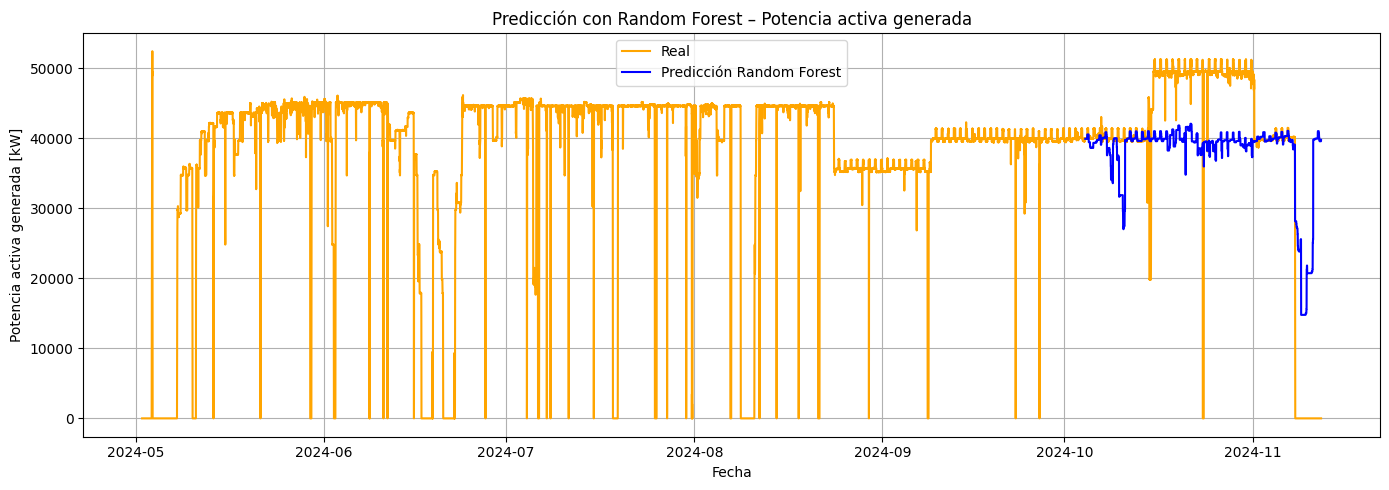

In [18]:
# 8. Graficar
fechas_test_RF = df_RF['Fecha'].iloc[-len(y_test_RF):]

plt.figure(figsize=(14, 5))
plt.plot(df_RF['Fecha'], y_RF, label='Real', color='orange')
plt.plot(fechas_test_RF, y_pred_RF, label='Predicción Random Forest', color='blue')
plt.title('Predicción con Random Forest – Potencia activa generada')
plt.xlabel('Fecha')
plt.ylabel('Potencia activa generada [kW]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# XGBOOST

In [19]:
# 1. Renombrar columnas para evitar errores con XGBoost
df_XGB = df.copy()
df_XGB.columns = df_XGB.columns.str.replace('[', '', regex=False).str.replace(']', '', regex=False)

# 2. Crear variables temporales
df_XGB['Hora'] = df_XGB['Fecha'].dt.hour
df_XGB['Minuto'] = df_XGB['Fecha'].dt.minute
df_XGB['Día'] = df_XGB['Fecha'].dt.day
df_XGB['Mes'] = df_XGB['Fecha'].dt.month
df_XGB['Año'] = df_XGB['Fecha'].dt.year
df_XGB['DíaSemana'] = df_XGB['Fecha'].dt.dayofweek


In [20]:
# 3. Definir variables predictoras (X) y objetivo (y)
X_XGB = df_XGB[['Hora', 'Minuto', 'Día', 'Mes', 'Año', 'DíaSemana']]

y_XGB = df_XGB['Potencia_activa_generada kW']

# 4. Dividir en entrenamiento y prueba (orden temporal)
X_train_XGB, X_test_XGB, y_train_XGB, y_test_XGB = train_test_split(X_XGB, y_XGB, shuffle=False, test_size=0.2)

In [21]:
# 5. Entrenar modelo XGBoost
modelo_XGB = XGBRegressor(n_estimators=150, max_depth=8, learning_rate=0.05,
                          subsample=0.8, random_state=42)
modelo_XGB.fit(X_train_XGB, y_train_XGB)



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=150, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [22]:
# 6. Predecir
y_pred_XGB = modelo_XGB.predict(X_test_XGB)

In [23]:
y_pred_XGB

array([39063.85 , 39092.85 , 38927.17 , ..., 39666.89 , 39724.21 ,
       39970.145], dtype=float32)

In [24]:
# 7. Evaluar métricas
mae_XGB = mean_absolute_error(y_test_XGB, y_pred_XGB)
rmse_XGB = np.sqrt(mean_squared_error(y_test_XGB, y_pred_XGB))
r2_XGB = r2_score(y_test_XGB, y_pred_XGB)

print(f"MAE XGBoost: {mae_XGB:.2f}")
print(f"RMSE XGBoost: {rmse_XGB:.2f}")
print(f"R² XGBoost: {r2_XGB:.4f}")

MAE XGBoost: 8047.69
RMSE XGBoost: 12325.58
R² XGBoost: 0.3279


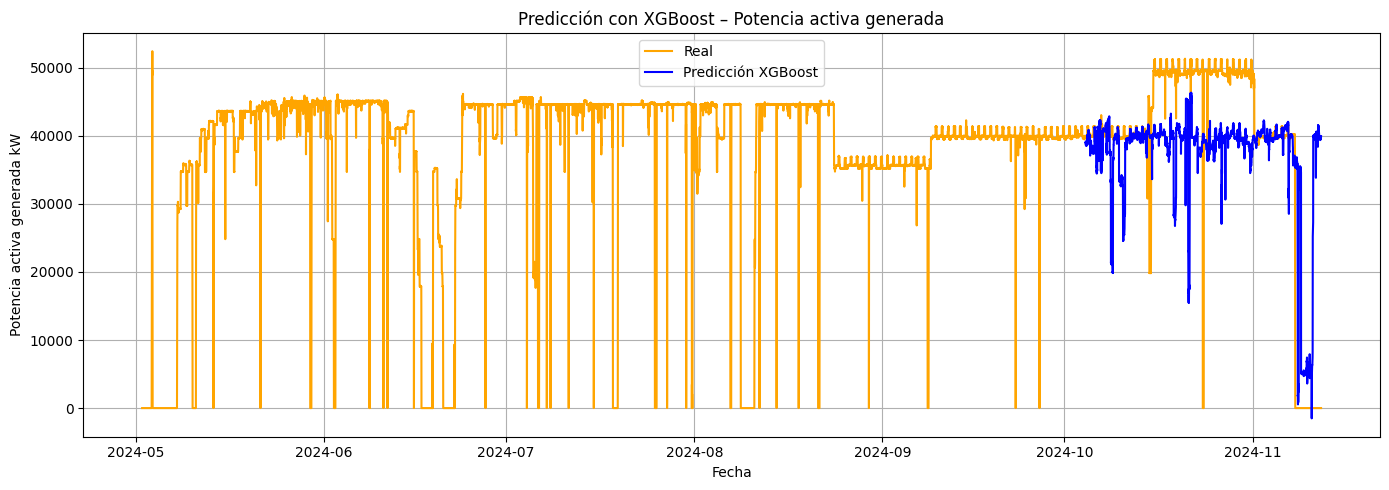

In [25]:
# 8. Graficar resultados reales vs predicción
fechas_test_XGB = df_XGB['Fecha'].iloc[-len(y_test_XGB):]

plt.figure(figsize=(14, 5))
plt.plot(df_XGB['Fecha'], y_XGB, label='Real', color='orange')
plt.plot(fechas_test_XGB, y_pred_XGB, label='Predicción XGBoost', color='blue')
plt.title('Predicción con XGBoost – Potencia activa generada')
plt.xlabel('Fecha')
plt.ylabel('Potencia activa generada kW')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# MLP

In [26]:
# 1. Cargar datos
df_MLP = df.copy()
# 2. Variables temporales
df_MLP['Hora'] = df_MLP['Fecha'].dt.hour
df_MLP['Minuto'] = df_MLP['Fecha'].dt.minute
df_MLP['Día'] = df_MLP['Fecha'].dt.day
df_MLP['Mes'] = df_MLP['Fecha'].dt.month
df_MLP['Año'] = df_MLP['Fecha'].dt.year
df_MLP['DíaSemana'] = df_MLP['Fecha'].dt.dayofweek


# 3. Variables predictoras y target
X_MLP = df_MLP[['Hora', 'Minuto', 'Día', 'Mes', 'Año', 'DíaSemana']]
y_MLP = df_MLP['Potencia_activa_generada [kW]']


In [27]:
# 4. Normalización
scaler_X = StandardScaler()
X_scaled_MLP = scaler_X.fit_transform(X_MLP)

In [28]:
# 5. Separar en entrenamiento y prueba
X_train_MLP, X_test_MLP, y_train_MLP, y_test_MLP = train_test_split(X_scaled_MLP, y_MLP,
                                                                    shuffle=False, test_size=0.2)


In [29]:
# 6. Modelo MLP
modelo_MLP = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=1000,
                          random_state=42)
modelo_MLP.fit(X_train_MLP, y_train_MLP)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)

In [30]:
# 7. Predicción
y_pred_MLP = modelo_MLP.predict(X_test_MLP)

In [31]:
y_pred_MLP

array([38867.79658904, 38683.32932952, 39154.18616346, ...,
       40234.49118859, 40238.50102649, 40160.73820114])

In [32]:
# 8. Métricas
mae_MLP = mean_absolute_error(y_test_MLP, y_pred_MLP)
rmse_MLP = np.sqrt(mean_squared_error(y_test_MLP, y_pred_MLP))
r2_MLP = r2_score(y_test_MLP, y_pred_MLP)
print(f"MAE MLP: {mae_MLP:.2f}")
print(f"RMSE MLP: {rmse_MLP:.2f}")
print(f"R² MLP  : {r2_MLP:.4f}")

MAE MLP: 7818.78
RMSE MLP: 14938.95
R² MLP  : 0.0127


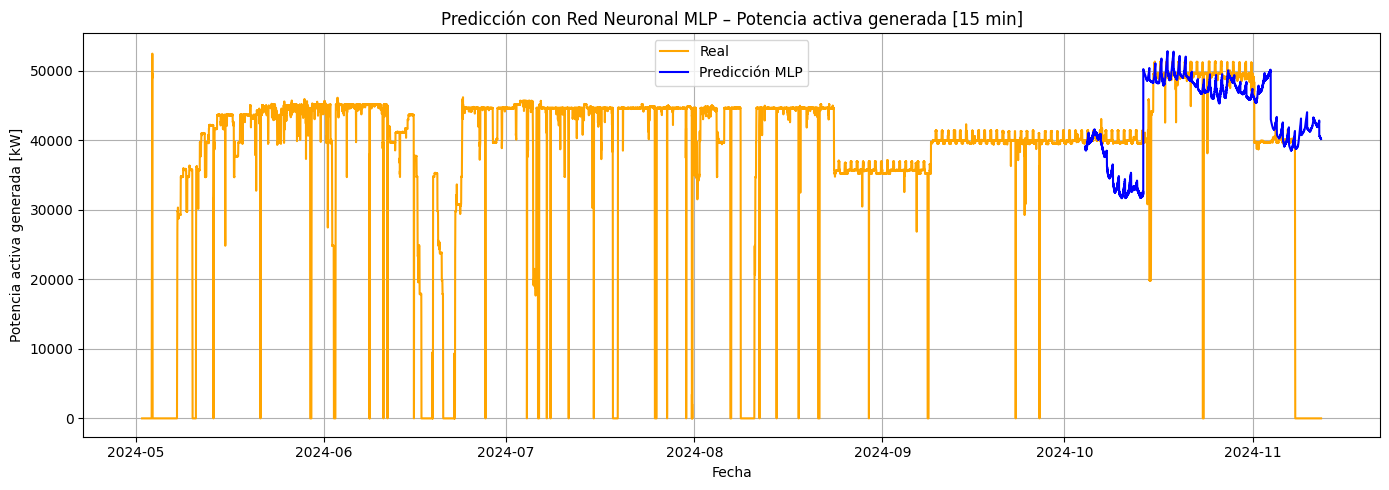

In [33]:
# 9. Graficar resultados
fechas_test_MLP = df_MLP['Fecha'].iloc[-len(y_test_MLP):]

plt.figure(figsize=(14, 5))
plt.plot(df_MLP['Fecha'], y_MLP, label='Real', color='orange')
plt.plot(fechas_test_MLP, y_pred_MLP, label='Predicción MLP', color='blue')
plt.title('Predicción con Red Neuronal MLP – Potencia activa generada [15 min]')
plt.xlabel('Fecha')
plt.ylabel('Potencia activa generada [kW]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# COMPARACION DE RESULTADOS

In [34]:
# Datos de evaluación
modelos = ['ARIMA', 'Random Forest', 'XGBoost', 'MLP']
mae = [mae_ARI, mae_RF, mae_XGB, mae_MLP]
rmse = [rmse_ARI, rmse_RF, rmse_XGB, rmse_MLP]
r2 = [r2_ARI, r2_RF, r2_XGB, r2_MLP]
# Crear DataFrame comparativo
df_comparacion = pd.DataFrame({
    'Modelo': modelos,
    'MAE': mae,
    'RMSE': rmse,
    'R²': r2
})
#Mostrar tabla
df_comparacion

,Modelo,MAE,RMSE,R²
0,ARIMA,9028.994803,15052.830059,-0.002386
1,Random Forest,8035.331032,11984.438338,0.364619
2,XGBoost,8047.688841,12325.577208,0.327932
3,MLP,7818.778409,14938.953172,0.012723


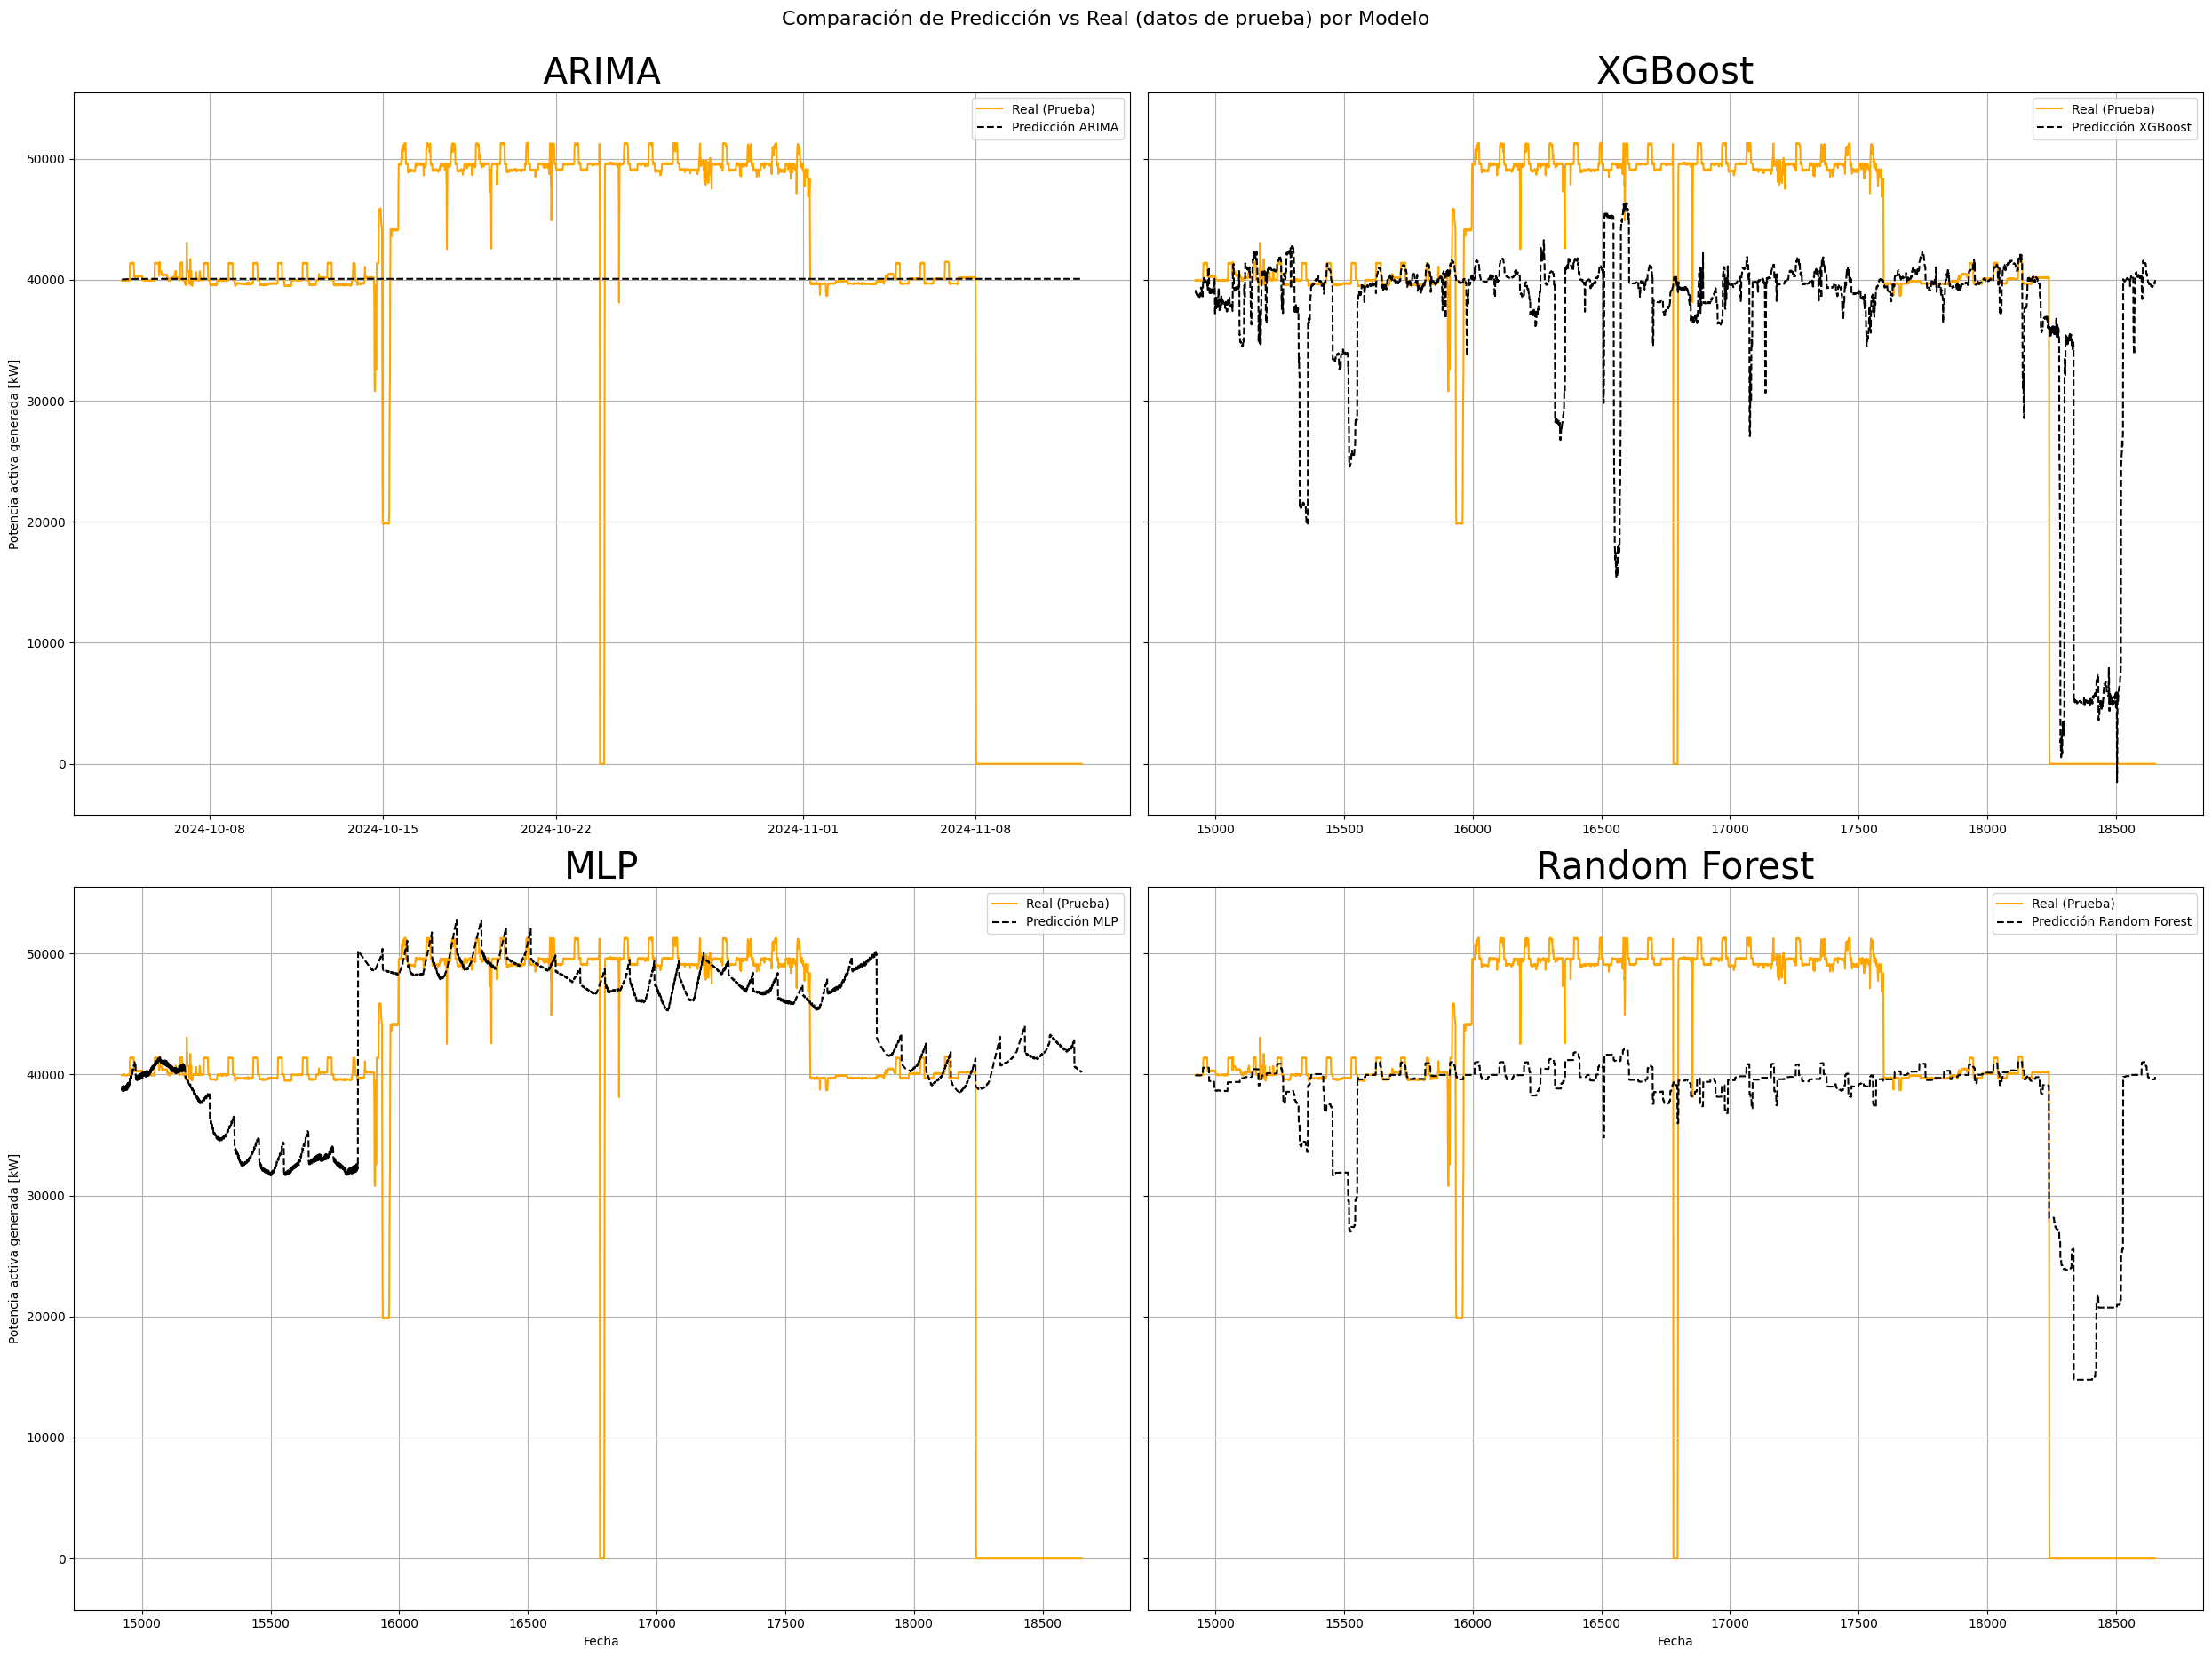

In [35]:
# Crear figura con 2 filas y 2 columnas
fig, axes = plt.subplots(2, 2, figsize=(25, 20), sharey=True)
fig.suptitle("Comparación de Predicción vs Real (datos de prueba) por Modelo", fontsize=16)

# === ARIMA ===
axes[0, 0].plot(test_ARI.index, test_ARI, label='Real (Prueba)', color='orange')
axes[0, 0].plot(test_ARI.index, pred_ARI, label='Predicción ARIMA', color='black', linestyle='--')
axes[0, 0].set_title("ARIMA", fontsize=30)
axes[0, 0].set_ylabel("Potencia activa generada [kW]")
axes[0, 0].legend()
axes[0, 0].grid(True)

# === XGBoost ===
axes[0, 1].plot(y_test_XGB.index, y_test_XGB, label='Real (Prueba)', color='orange')
axes[0, 1].plot(y_test_XGB.index, y_pred_XGB, label='Predicción XGBoost', color='black', linestyle='--')
axes[0, 1].set_title("XGBoost", fontsize=30)
axes[0, 1].legend()
axes[0, 1].grid(True)

# === MLP ===
axes[1, 0].plot(y_test_MLP.index, y_test_MLP, label='Real (Prueba)', color='orange')
axes[1, 0].plot(y_test_MLP.index, y_pred_MLP, label='Predicción MLP', color='black', linestyle='--')
axes[1, 0].set_title("MLP", fontsize=30)
axes[1, 0].set_xlabel("Fecha")
axes[1, 0].set_ylabel("Potencia activa generada [kW]")
axes[1, 0].legend()
axes[1, 0].grid(True)

# === Random Forest ===
axes[1, 1].plot(y_test_RF.index, y_test_RF, label='Real (Prueba)', color='orange')
axes[1, 1].plot(y_test_RF.index, y_pred_RF, label='Predicción Random Forest', color='black', linestyle='--')
axes[1, 1].set_title("Random Forest", fontsize=30)
axes[1, 1].set_xlabel("Fecha")
axes[1, 1].legend()
axes[1, 1].grid(True)

# Ajuste final
plt.tight_layout(rect=[0, 0.05, 1, 0.98])
plt.show()
